In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import resnet34
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

from custom_datasets import PascalDataset

In [2]:
DATA_DIR = Path('../data/pascal')
JPEG_DIR = DATA_DIR/'VOCdevkit/VOC2007/JPEGImages'
CSVS_DIR = DATA_DIR/'csvs'
data = json.load((DATA_DIR/'pascal_train2007.json').open())

DATA_IMAGES, DATA_TYPE, DATA_ANNOTATIONS, DATA_CATEGORIES = data['images'], data['type'], data['annotations'], data['categories']

category_dic = {x['id']:x['name'] for x in DATA_CATEGORIES}
jpeg_dic = {x['id']:x for x in DATA_IMAGES}
annotations_dic = defaultdict(lambda : []) 

for ann in DATA_ANNOTATIONS:
    if ann['ignore']==0:
        annotations_dic[ann['image_id']].append((ann['bbox'],ann['category_id'])) 

Training set jpeg images: 2501, total annotations: 7844, without ignore: 6301

#2501 images mean, std
#mean - array([ 0.44725656,  0.42312961,  0.39120578])
#std - array([ 0.24063791,  0.23445822,  0.2372444 ])

# To calculate mean, std of images in trn set
mean = np.zeros(3)
std = np.zeros(3)
for idx in train_idxs:
    im_array = np.asarray(Image.open(JPEG_DIR/DATA_IMAGES[idx]['file_name']))
    mean += im_array.mean(axis=(0,1))      #H x W x 3
    std += im_array.std(axis=(0,1))

print(mean/(255*len(train_idxs)))
print(std/(255*len(train_idxs)))

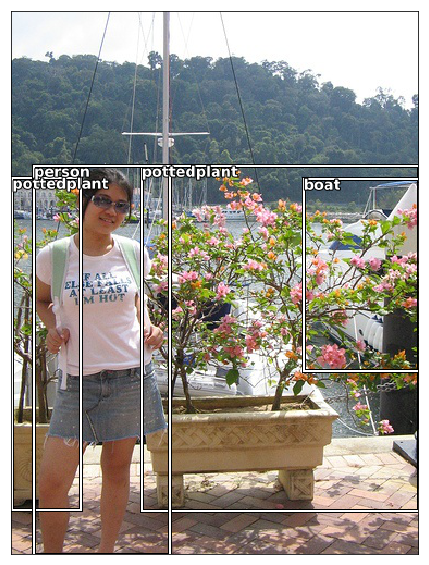

In [3]:
plot_utils.plot_trn_image_with_annotations(73, jpeg_dic, JPEG_DIR, annotations_dic, category_dic)    #9668

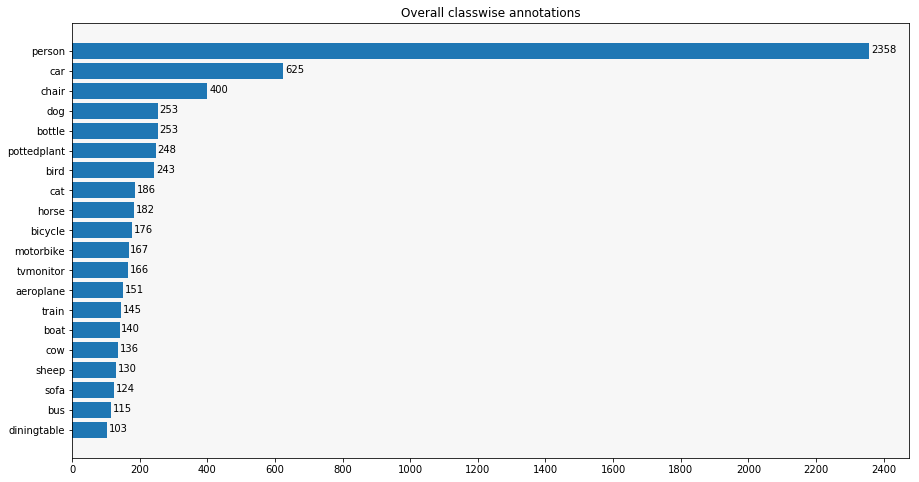

In [5]:
labels = list(category_dic.values())
counts = np.zeros(20)
for im_id, annotations in annotations_dic.items():
    for ann in annotations:
        idx = ann[1]-1
        counts[idx] +=1

plot_utils.plot_horizontal_bar_chart(counts, labels, title='Overall classwise annotations')        

In [ ]:
# Creating csv data for largest item classifier model
'''
largest_ann_dic = defaultdict(lambda:())

for im_id, ann in annotations_dic.items():
    largest_ann_dic[im_id] = sorted(annotations_dic[im_id], key=lambda x: x[0][2]*x[0][3], reverse=True)[0] or ()
    
df = pd.DataFrame(data={'file_name': [file['file_name'] for file in DATA_IMAGES], 
                        'category': [category_dic[largest_ann_dic[file['id']][1]] for file in DATA_IMAGES]})

df.to_csv(CSVS_DIR/'largest_item_classifier.csv',index=False)
'''

In [3]:
largest_item_classifier_csv = pd.read_csv(CSVS_DIR/'largest_item_classifier.csv')

In [31]:
#res = largest_item_classifier_csv.groupby('category')['file_name'].nunique()
#plot_utils.plot_horizontal_bar_chart(res, res.keys(), title='largest item occurances in images', x_tick_step=50)        

In [4]:
train_idxs, val_idxs = model_utils.get_trn_val_idxs(len(largest_item_classifier_csv))

In [5]:
bs = 64
sz = 224
n_epochs = 5
lr = 0.0001
mean = torch.Tensor([ 0.4475,  0.4240,  0.3919]).reshape((3,1,1)) 
std = torch.Tensor([ 0.2403,  0.2343,  0.2367]).reshape((3,1,1))

train_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()#,
    #transforms.Normalize(mean, std)
])

val_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()#,
    #transforms.Normalize(mean, std)     
])

In [6]:
pas_train_dl = torch.utils.data.DataLoader(PascalDataset(CSVS_DIR/'largest_item_classifier.csv', JPEG_DIR, train_tfms),
                                           bs, 
                                           sampler=SubsetRandomSampler(train_idxs))

pas_val_dl = torch.utils.data.DataLoader(PascalDataset(CSVS_DIR/'largest_item_classifier.csv', JPEG_DIR, val_tfms), 
                                         bs, 
                                         sampler=SubsetRandomSampler(val_idxs))

In [7]:
model = resnet34(pretrained=True)
#model.fc = nn.Linear(512, 20)   
model = model.to(device)

In [8]:
model.load_state_dict(torch.load(DATA_DIR/'my-models/largest_item_classifier-86.13_train_acc.ckpt', map_location='cpu'))

In [ ]:
model.train()
lr = 0.0001
n_epochs = 5 
logger = model_utils.create_tensorboard_logger('./logs/largest_item_classfier/run_1')
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in pas_train_dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        optimizer.step()
                
        pred_labels = preds.argmax(dim=1)

        total_steps +=1
        
        batch_accuracy = (labels == pred_labels).float().mean()
        log_info = {'loss': loss.item(), 'accuracy': batch_accuracy.item()}
        
        model_utils.log_scalars_to_tensorboard_logger(logger, log_info, total_steps)                                                    
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(pas_train_dl))

In [10]:
preds, batch, actual_labels = model_utils.get_model_predictions_on_a_sample_batch(model, pas_val_dl)
pred_labels = preds.argmax(dim=1)

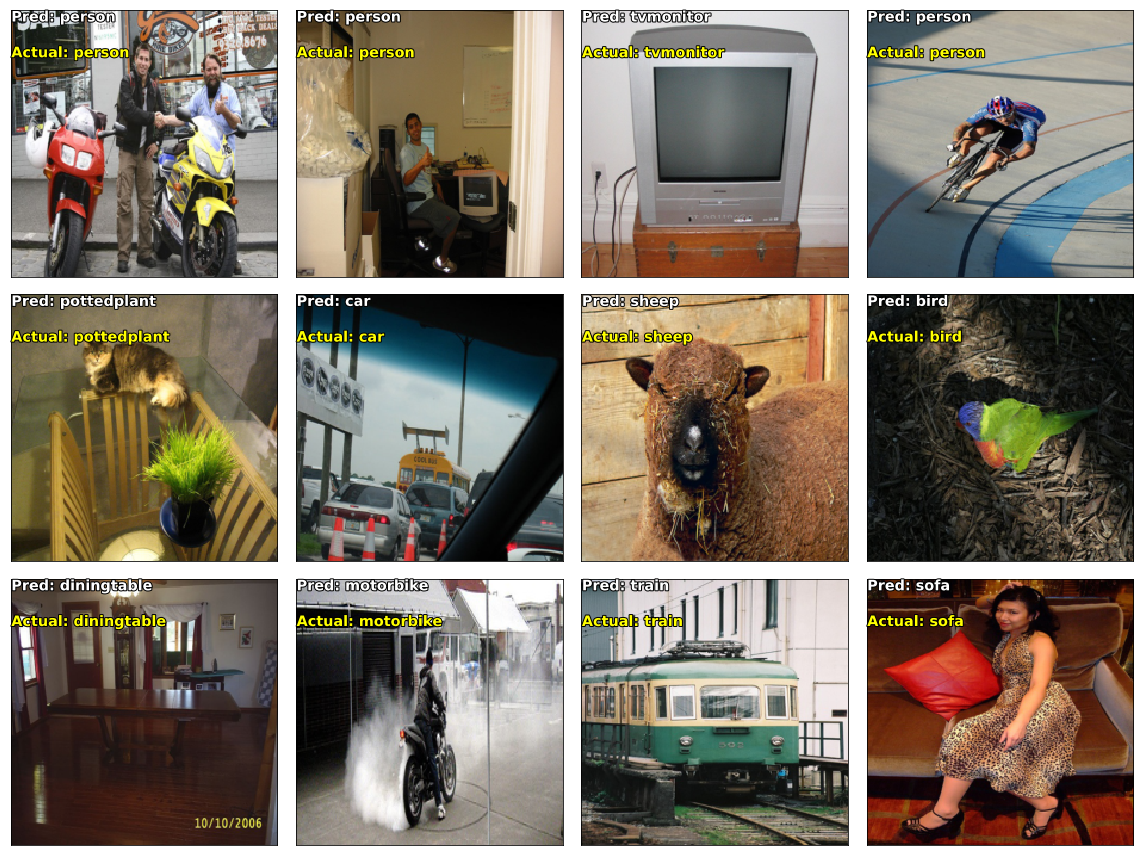

In [11]:
plot_utils.plot_model_predictions_on_sample_batch(batch, pred_labels, actual_labels, 
                                                        pas_train_dl.dataset.get_category_label)